# Fit for $\alpha$ and $\epsilon$ and small separations

In our latent variable model, we state that the radial mode frequencies are determined by the asymptotic relation ([Vrard et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...579A..84V/abstract)) with some scatter: 

$\large\nu_{l} = (\bar{n} + \epsilon + \delta_{l} + (\frac{\alpha}{2}(\bar{n} - \frac{\nu_{\rm max}}{\Delta\nu} + \epsilon)^2)) \Delta\nu$

where $\nu_{\rm l}$ is the frequency locations of all l modes at overtones $\bar{n}$, $\epsilon$ is the phase offset, $\alpha$ determines the curvature, $\Delta\nu$ is the large separation, and $\delta_{l}$ is the small separation, where $\delta_{l=0} = 0$. Note that in this notation they are defined as fractions of $\Delta\nu$.

A bunch of these are free parameters in our model. We want to include prior information from the LEGACY and Kages samples when fitting our model, and we can do so by using the values for these hyperparameters derived from their data as the means on our prior distributions.

Some of these parameters (e.g. $\nu_{\rm max}$, $\Delta\nu$) are reported in the literature. The parameters specific to this asymptotic relation, $\epsilon$ and $\alpha$, are not. 

In order to obtain a quick measurement of these values, we'll run fit a model to the frequencies of each star, fitting for $\nu_{\rm max}$, $\delta_l$ and $\epsilon$ and $\alpha$ as free parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz
import pandas as pd
import mystyle as ms
from astropy.io import ascii

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
mal = pd.read_csv('../../data/malatium.csv', index_col=0)

In [3]:
cop = pd.read_csv('../../data/copper.csv',index_col=0)

Lets test on a single target first...

In [4]:
kic = 3632418

In [5]:
class model():
    def __init__(self, n0, n1, n2, numax, deltanu):
        self.n0 = n0
        self.n1 = n1
        self.n2 = n2
        self.numax = numax
        self.deltanu = deltanu
        
    # Small separations are fractional
    def asymptotic(self, n, numax, alpha, epsilon, d=0.): 
        nmax = (numax / self.deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * self.deltanu
    
    def f0(self, p):
        alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, self.numax, alpha, epsilon, 0.)
    
    def f1(self, p):
        alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, self.numax, alpha, epsilon, d01)
    
    def f2(self, p):
        alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, self.numax, alpha, epsilon, -d02)

In [6]:
n0 = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].n.values
n1 = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].n.values
n2 = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].n.values

numax_ = mal.loc[mal.KIC == kic].numax.values[0]
deltanu_ = mal.loc[mal.KIC == kic].dnu.values[0]

l0s = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].Freq.values
e_l0s = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].e_Freq.values
l1s = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].Freq.values
e_l1s = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].e_Freq.values
l2s = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].Freq.values
e_l2s = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].e_Freq.values

In [7]:
mod = model(n0, n1, n2, numax_, deltanu_)

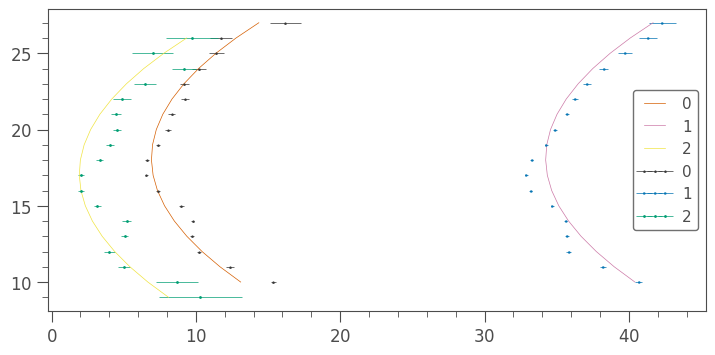

In [9]:
init = [.0031,  #alpha
        1.114,    #epsilon
        0.45, #d01
        5./deltanu_ #d02
       ]

with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    ax.errorbar(l0s%deltanu_, n0, xerr=e_l0s, fmt='^',label='0')
    ax.errorbar(l1s%deltanu_, n1, xerr=e_l1s, fmt='>',label='1')
    ax.errorbar(l2s%deltanu_, n2, xerr=e_l2s, fmt='o',label='2')

    ax.plot(mod.f0(init)%deltanu_, n0, label='0')
    ax.plot(mod.f1(init)%deltanu_, n1, label='1')
    ax.plot(mod.f2(init)%deltanu_, n2, label='2')
    
    ax.legend()      

# Let's build the model

In [10]:
pm_model = pm.Model()
BoundedNormal = pm.Bound(pm.Normal, lower= 0.0)
with pm_model:
    #Parameters
    alpha = pm.HalfNormal('alpha', sigma=1., testval=0.02)
    epsilon = BoundedNormal('epsilon', mu=1., sigma=1., testval=1.)
    d01 = BoundedNormal('d01', mu=0.5, sigma=.1, testval=0.5)
    d02 = BoundedNormal('d02', mu=0.1,  sigma=.3, testval=0.1)
    
    # Model
    p = [alpha, epsilon, d01, d02]
    nul0s = pm.Deterministic('nul0s', mod.f0(p))
    nul1s = pm.Deterministic('nul1s', mod.f1(p))
    nul2s = pm.Deterministic('nul2s', mod.f2(p))
    
    like0 = pm.Normal('like0', mu=nul0s, sigma=e_l0s, observed=l0s)
    like1 = pm.Normal('like1', mu=nul1s, sigma=e_l1s, observed=l1s)
    like2 = pm.Normal('like2', mu=nul2s, sigma=e_l2s, observed=l2s)

In [11]:
init = 5000
with pm_model:
    trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:28<00:00, 708.07draws/s] 


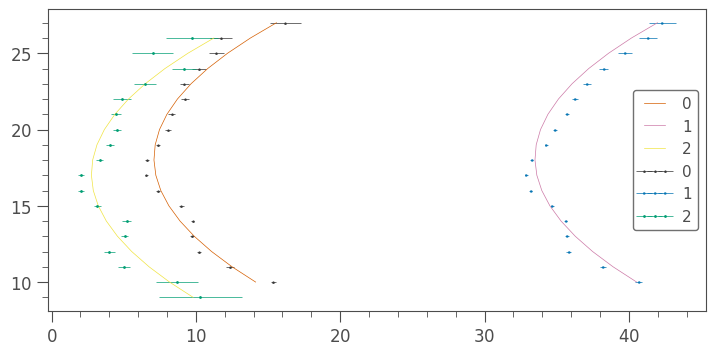

In [12]:
res = [np.median(trace[label]) for label in ['alpha','epsilon','d01','d02']]

with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    ax.errorbar(l0s%deltanu_, n0, xerr=e_l0s, fmt='^',label='0')
    ax.errorbar(l1s%deltanu_, n1, xerr=e_l1s, fmt='>',label='1')
    ax.errorbar(l2s%deltanu_, n2, xerr=e_l2s, fmt='o',label='2')

    ax.plot(mod.f0(res)%deltanu_, n0, label='0')
    ax.plot(mod.f1(res)%deltanu_, n1, label='1')
    ax.plot(mod.f2(res)%deltanu_, n2, label='2')
    
    ax.legend()

Lets just make this aligns with the literature value before continuing...

I'll check the small separation and epsilon areughly in the right ballpark, but not to within the errors, because we're not treating the very obvious glitches.

In [15]:
import sys
if not (np.isclose(1.114, res[1], atol=0.009)) & (np.isclose(4.189/deltanu_, res[2], atol=1.)):
    sys.exit()

# Lets run on the whole sample!

In [16]:
cadmium = pd.DataFrame()
cadmium['KIC'] = mal.KIC.copy()
cadmium['alpha'] = np.nan
cadmium['e_alpha'] = np.nan
cadmium['epsilon'] = np.nan
cadmium['e_epsilon'] = np.nan
cadmium['d01'] = np.nan
cadmium['d02'] = np.nan
cadmium.head(1)

,KIC,alpha,e_alpha,epsilon,e_epsilon,d01,d02
0,1435467,NaN,NaN,NaN,NaN,NaN,NaN


Running KIC: 1435467


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:10<00:00, 1995.06draws/s]


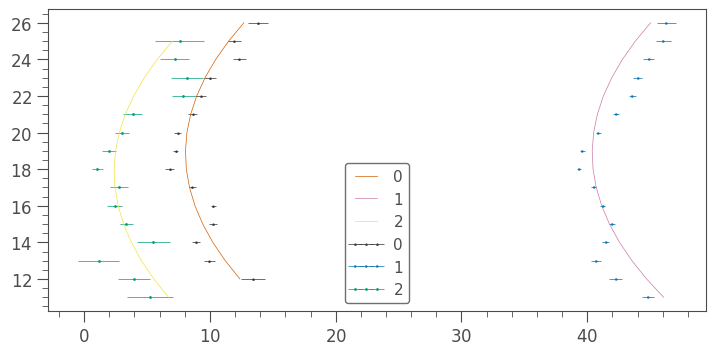

Running KIC: 2837475


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:10<00:00, 1887.56draws/s]


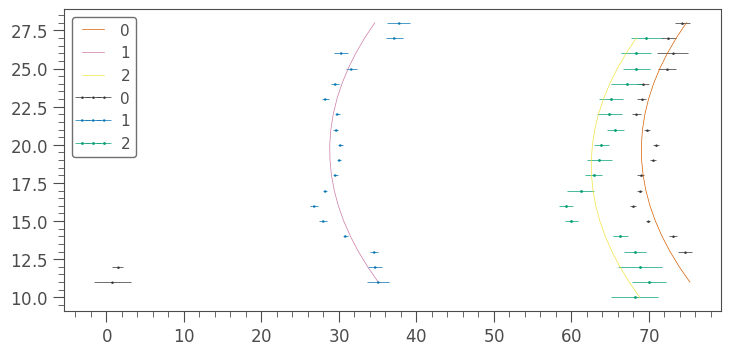

Running KIC: 3427720


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:22<00:00, 892.49draws/s] 


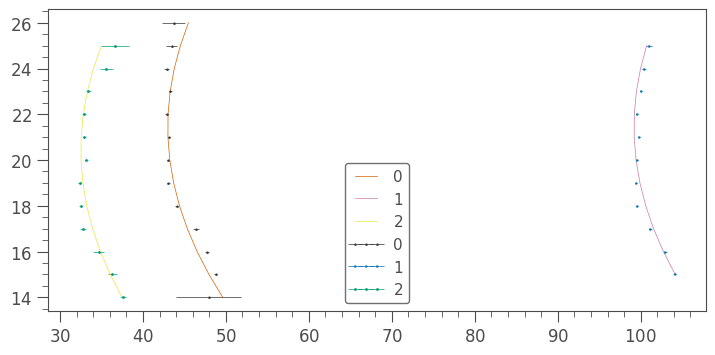

Running KIC: 3456181


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:26<00:00, 753.15draws/s] 


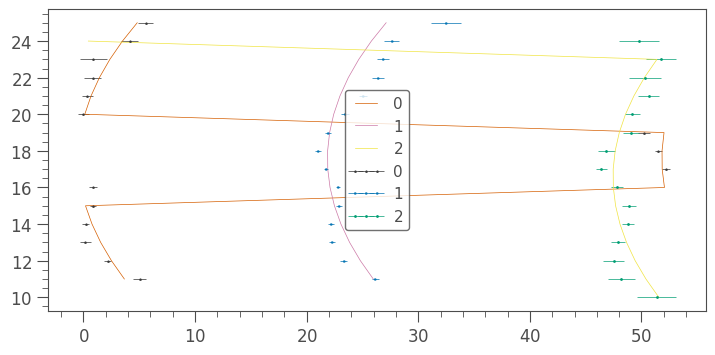

Running KIC: 3632418


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:22<00:00, 908.16draws/s] 


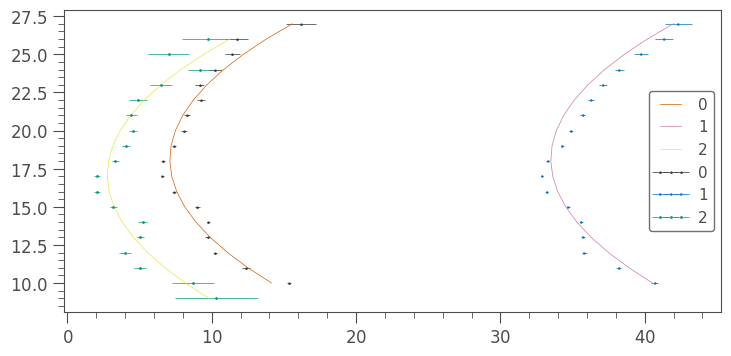

Running KIC: 3656476


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:26<00:00, 760.83draws/s] 


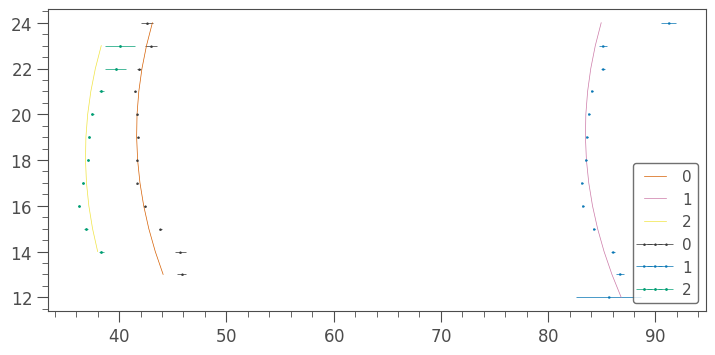

Running KIC: 3735871


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:14<00:00, 1354.26draws/s]


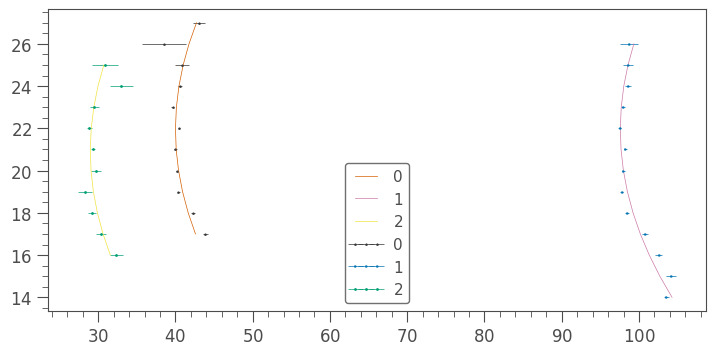

Running KIC: 4914923


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:13<00:00, 1525.98draws/s]


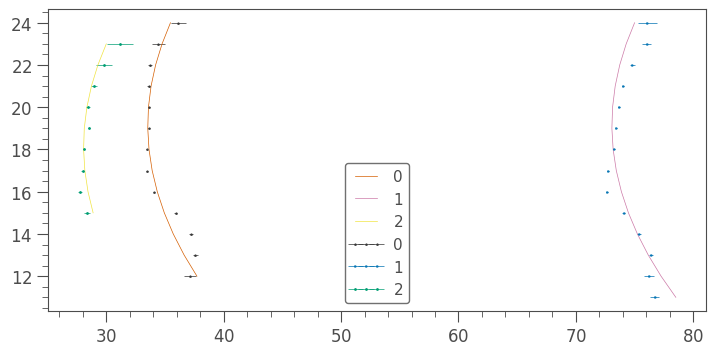

Running KIC: 5184732


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2635.99draws/s]


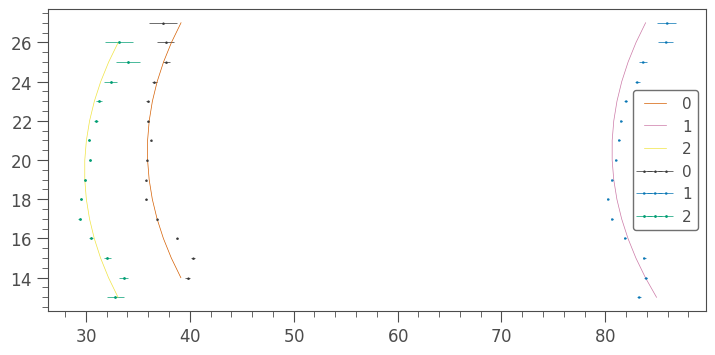

Running KIC: 5773345


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2432.92draws/s]


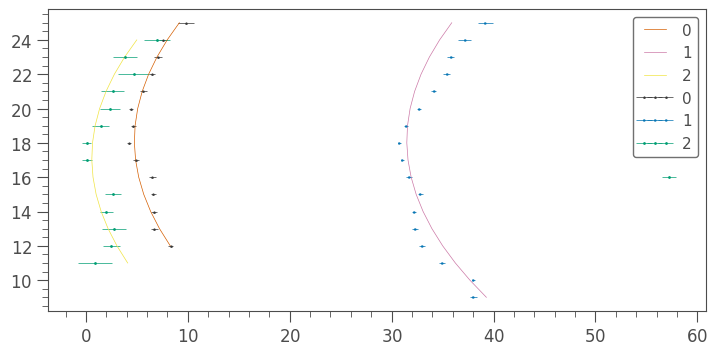

Running KIC: 5950854


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2443.20draws/s]


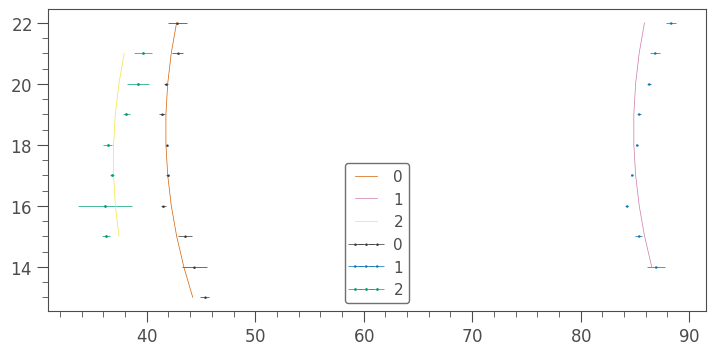

Running KIC: 6106415


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2061.00draws/s]


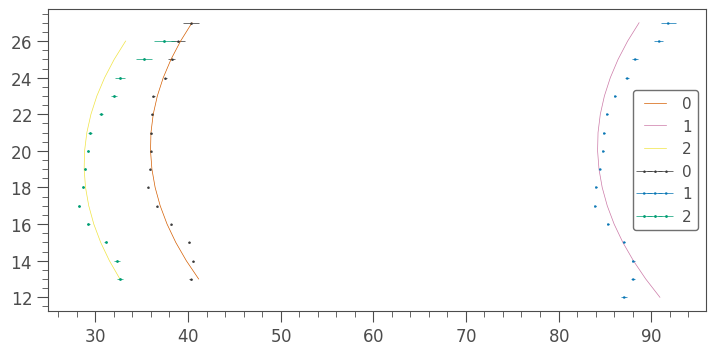

Running KIC: 6116048


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:18<00:00, 1069.18draws/s]


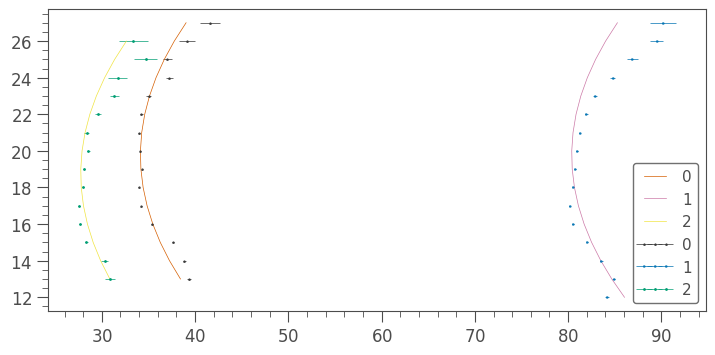

Running KIC: 6225718


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:10<00:00, 1892.61draws/s]
The acceptance probability does not match the target. It is 0.6930295851259062, but should be close to 0.8. Try to increase the number of tuning steps.


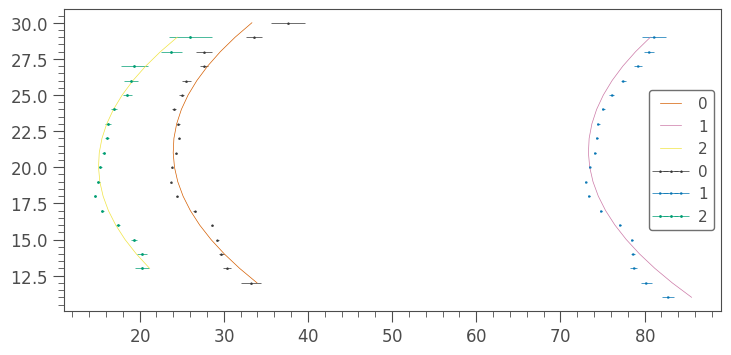

Running KIC: 6508366


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2200.79draws/s]


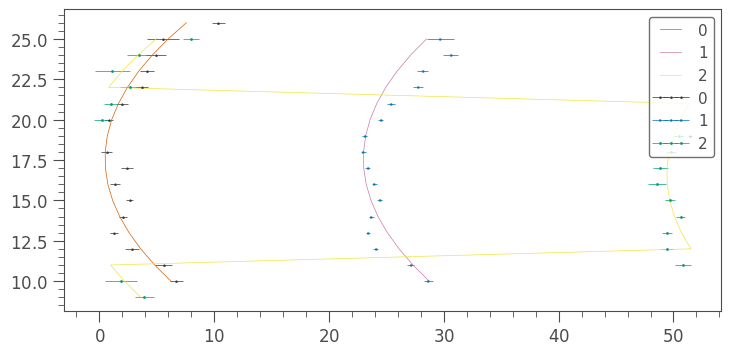

Running KIC: 6603624


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:26<00:00, 748.67draws/s] 


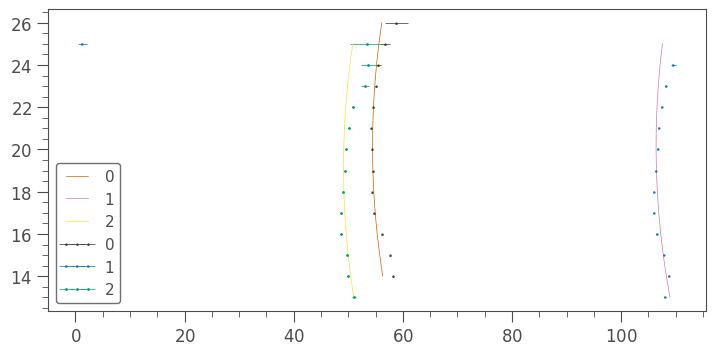

Running KIC: 6679371


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:21<00:00, 948.46draws/s] 


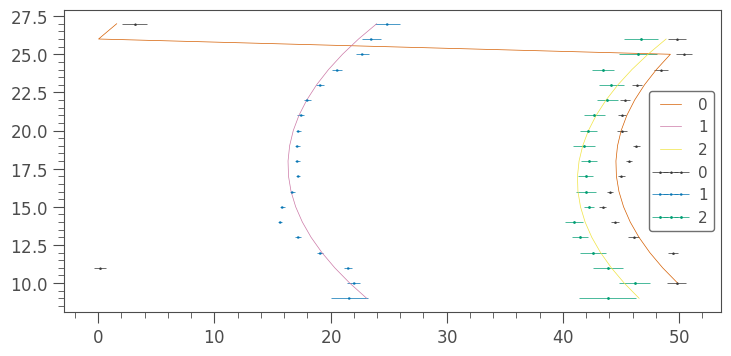

Running KIC: 6933899


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:17<00:00, 1125.44draws/s]


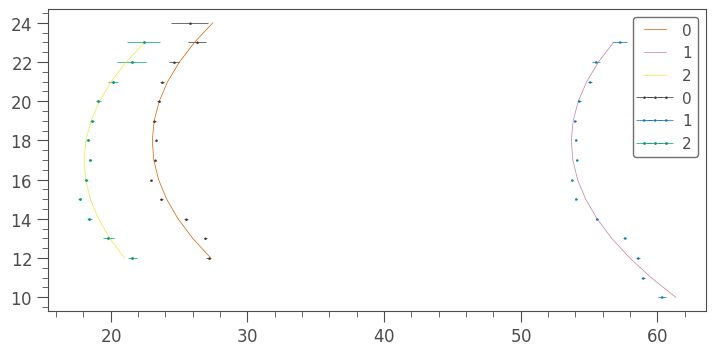

Running KIC: 7103006


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:19<00:00, 1026.25draws/s]


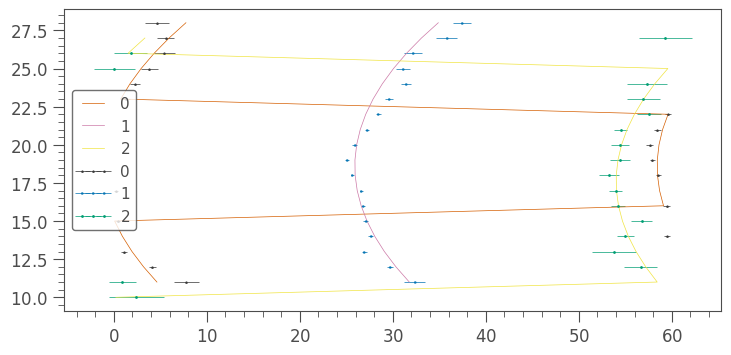

Running KIC: 7106245


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:22<00:00, 875.89draws/s] 


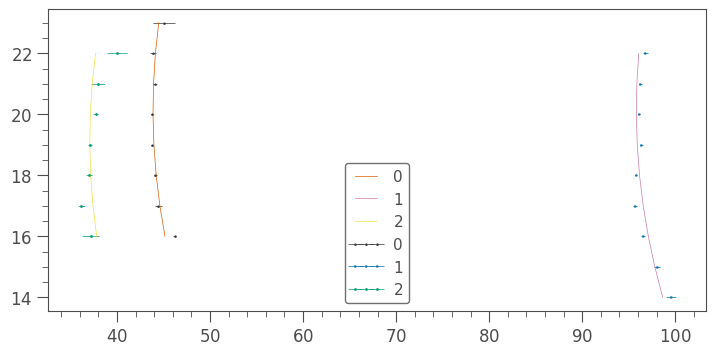

Running KIC: 7206837


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:15<00:00, 1287.54draws/s]


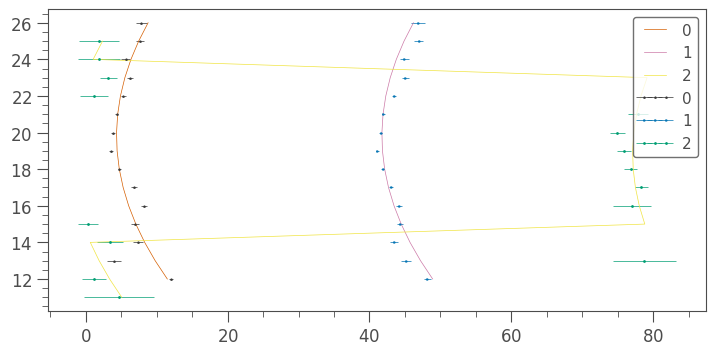

Running KIC: 7296438


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2212.27draws/s]


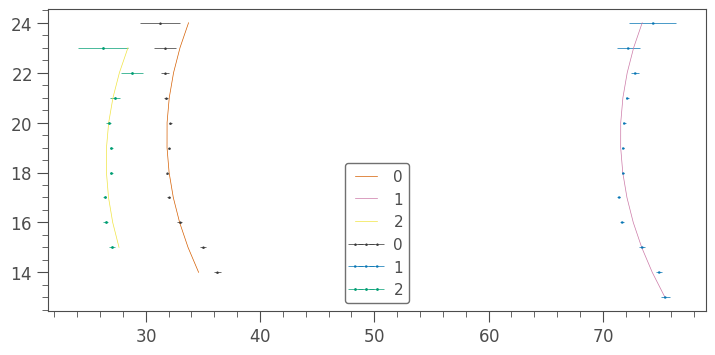

Running KIC: 7510397


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2406.46draws/s]


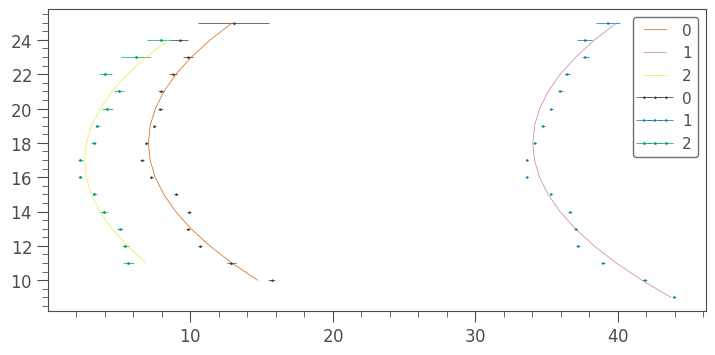

Running KIC: 7680114


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2200.72draws/s]


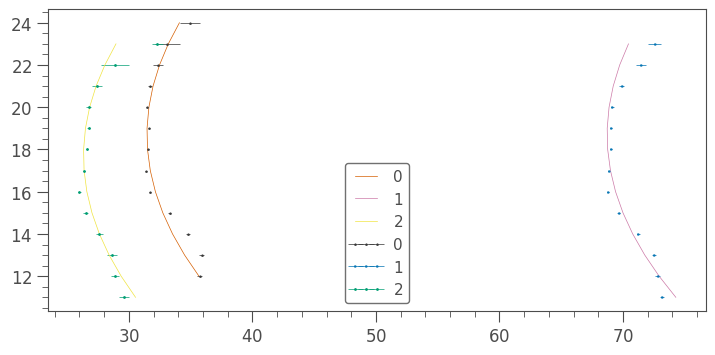

Running KIC: 7771282


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2311.59draws/s]


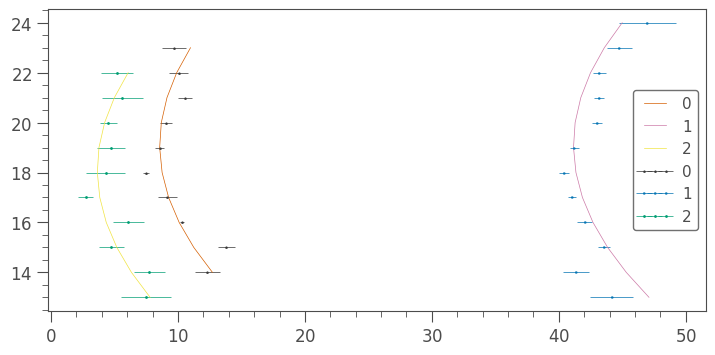

Running KIC: 7871531


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2038.27draws/s]


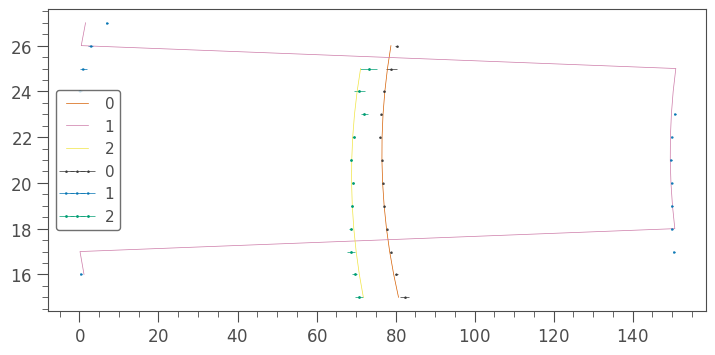

Running KIC: 7940546


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2318.09draws/s]


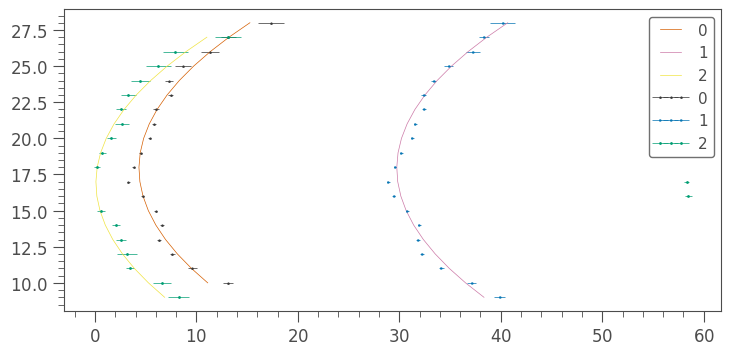

Running KIC: 7970740


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:10<00:00, 1827.16draws/s]


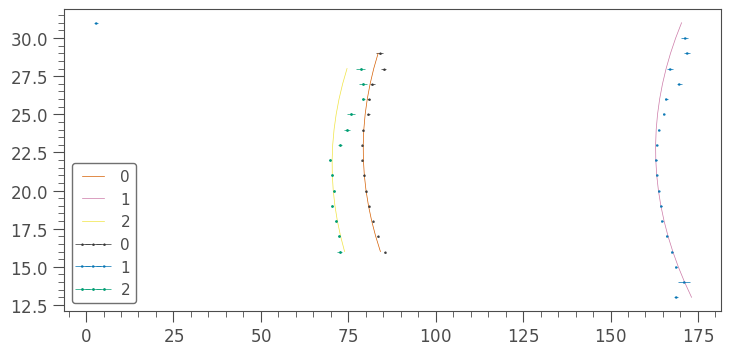

Running KIC: 8006161


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:24<00:00, 819.15draws/s] 


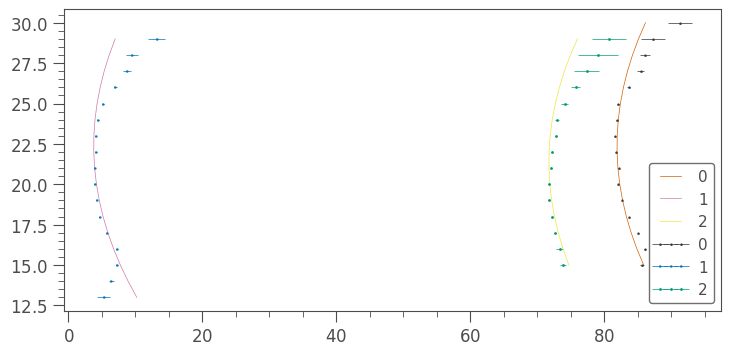

Running KIC: 8150065


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2246.22draws/s]


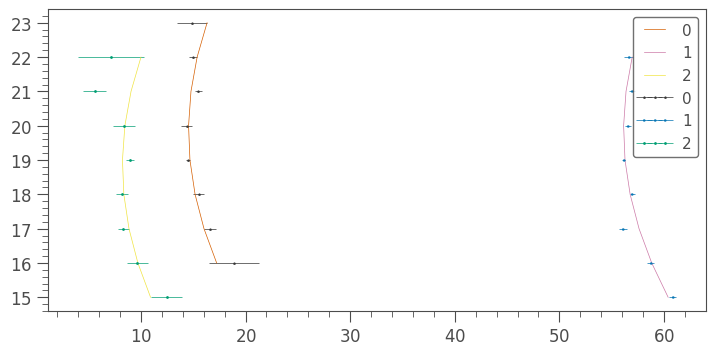

Running KIC: 8179536


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2292.79draws/s]


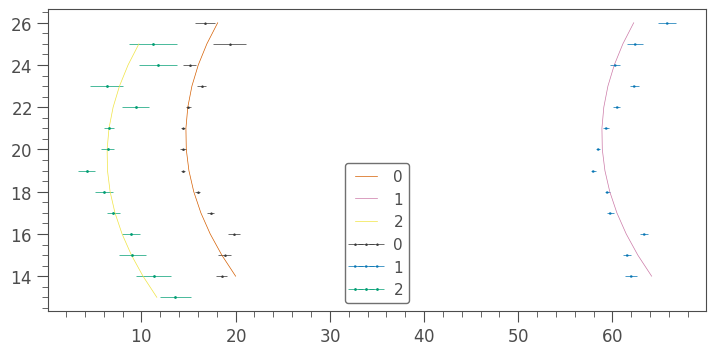

Running KIC: 8228742


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2343.65draws/s]


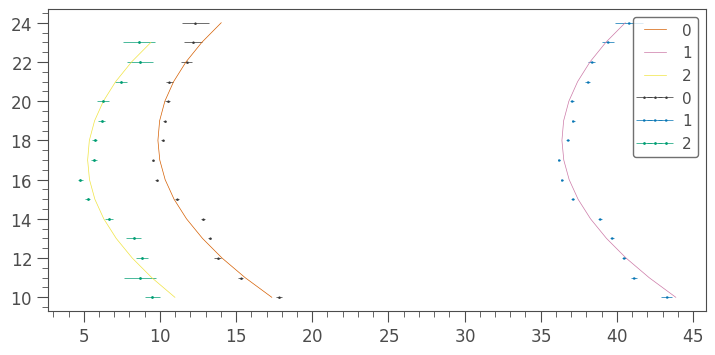

Running KIC: 8379927


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:17<00:00, 1129.69draws/s]


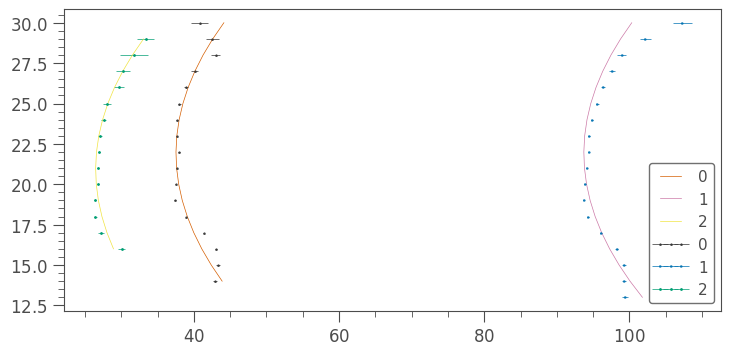

Running KIC: 8394589


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2593.60draws/s]


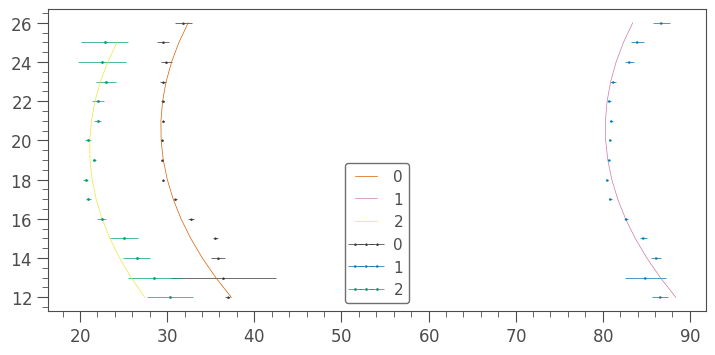

Running KIC: 8424992


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2370.31draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


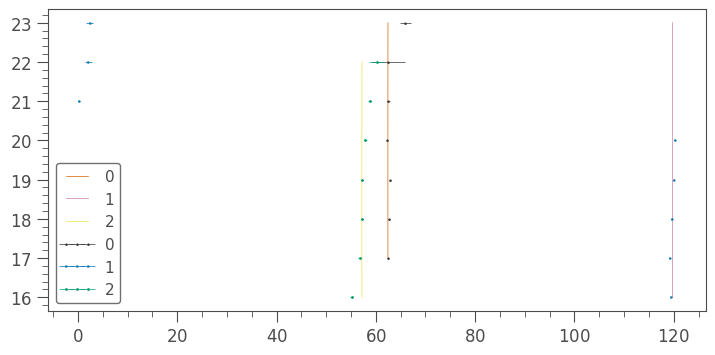

Running KIC: 8694723


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2340.33draws/s]


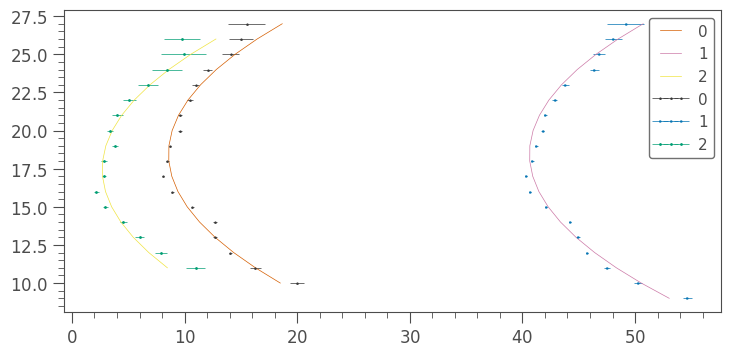

Running KIC: 8760414


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:22<00:00, 878.34draws/s] 


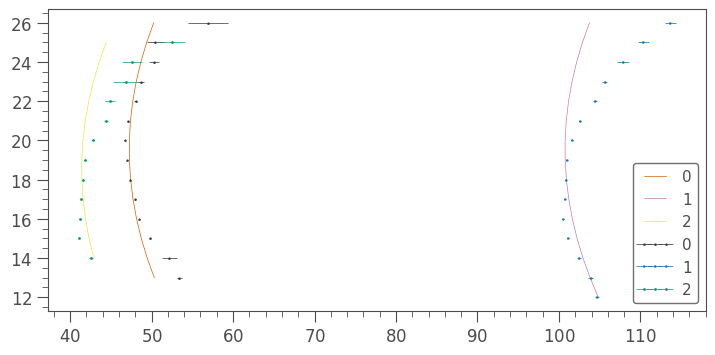

Running KIC: 8938364


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2298.98draws/s]


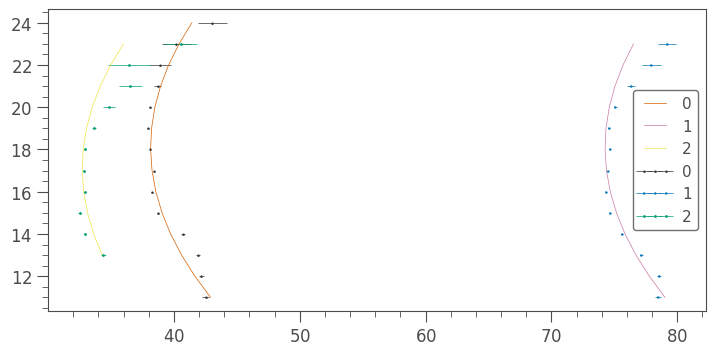

Running KIC: 9025370


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2473.68draws/s]


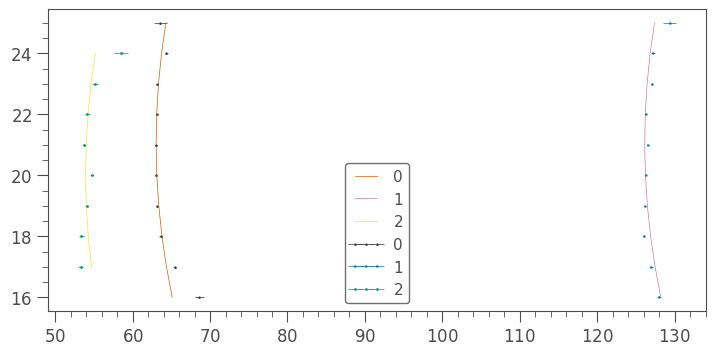

Running KIC: 9098294


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2295.99draws/s]


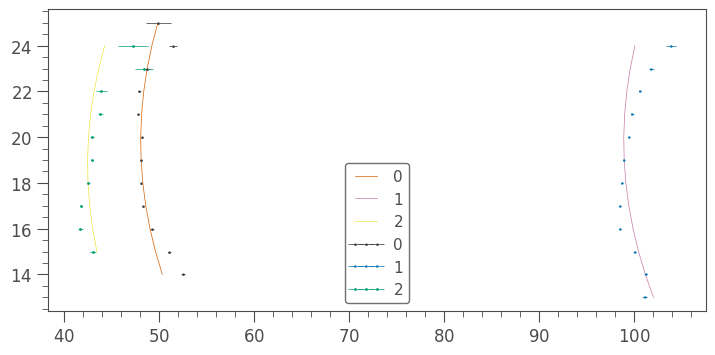

Running KIC: 9139151


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2445.25draws/s]


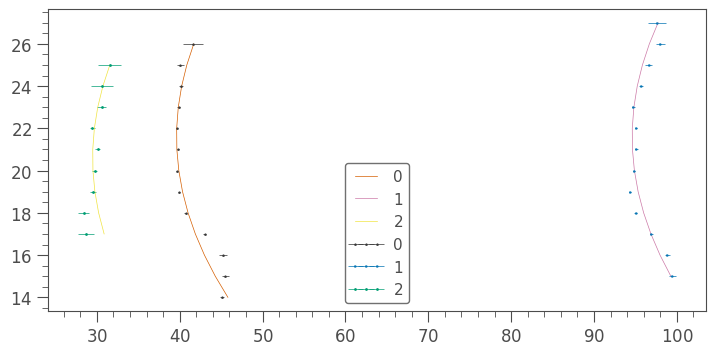

Running KIC: 9139163


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2149.75draws/s]


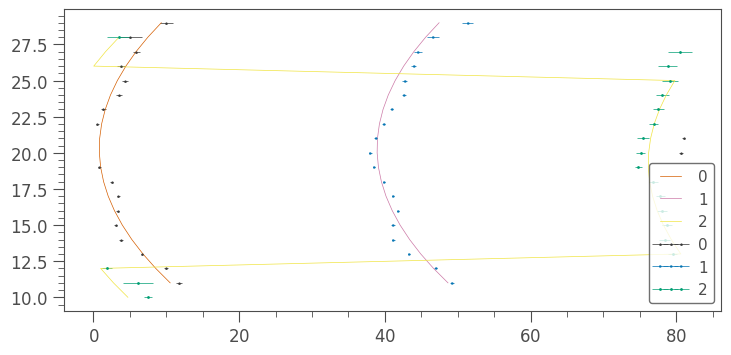

Running KIC: 9206432


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2309.07draws/s]


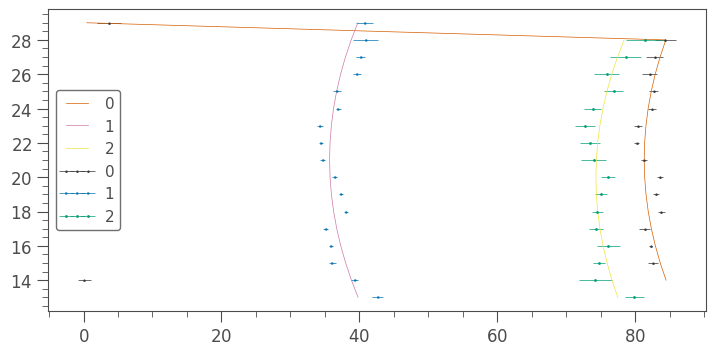

Running KIC: 9353712


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 1030.42draws/s]


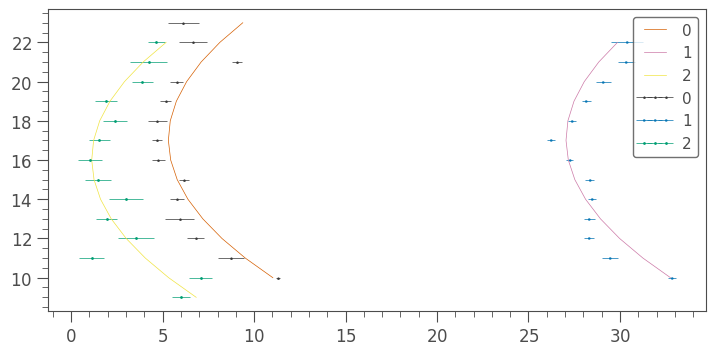

Running KIC: 9410862


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2266.55draws/s]


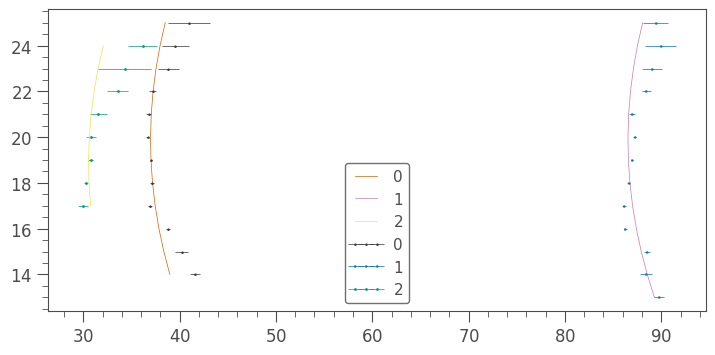

Running KIC: 9414417


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2175.66draws/s]


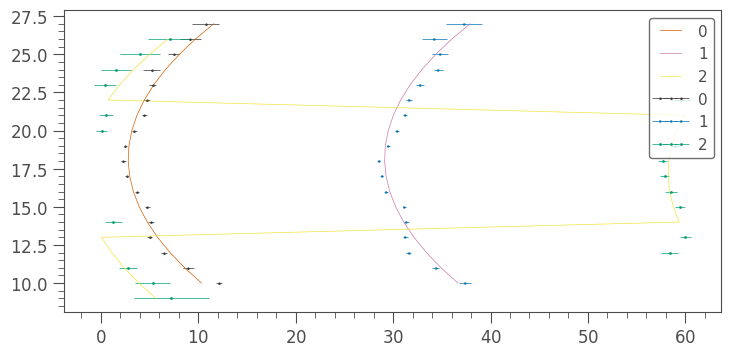

Running KIC: 9812850


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2302.85draws/s]


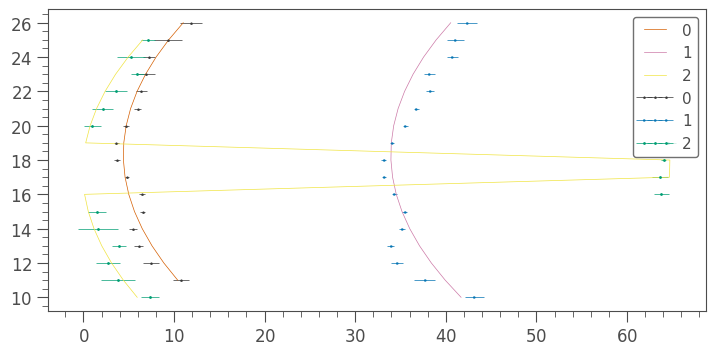

Running KIC: 9955598


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:12<00:00, 1613.50draws/s]


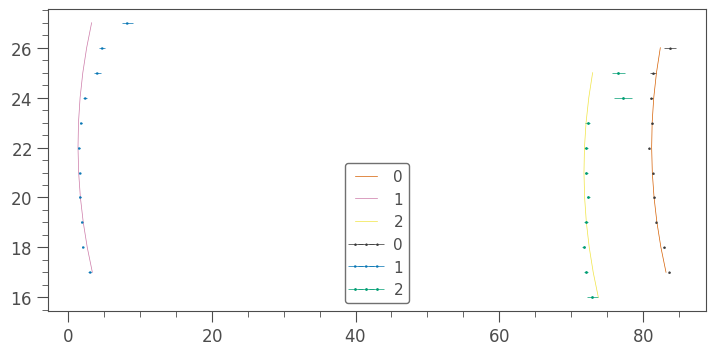

Running KIC: 9965715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2443.06draws/s]


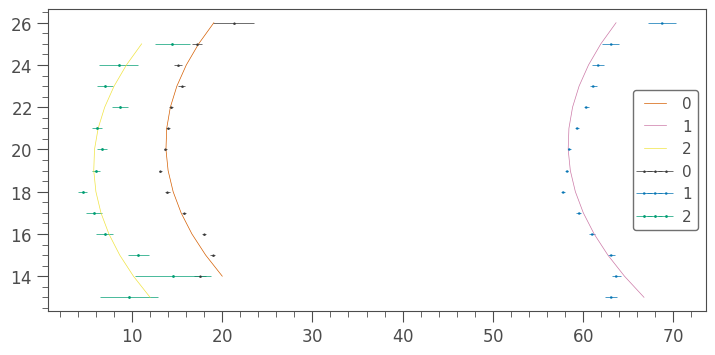

Running KIC: 10068307


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2109.19draws/s]


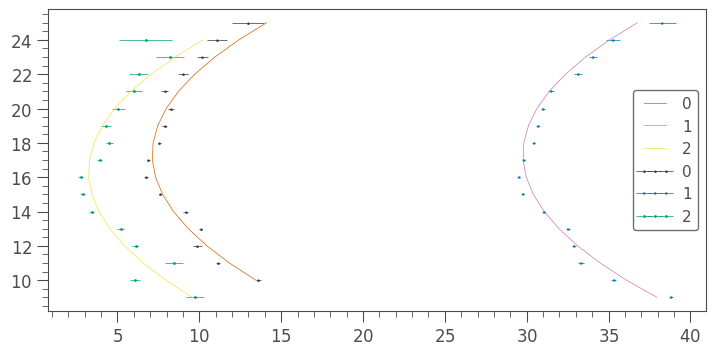

Running KIC: 10079226


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2281.35draws/s]


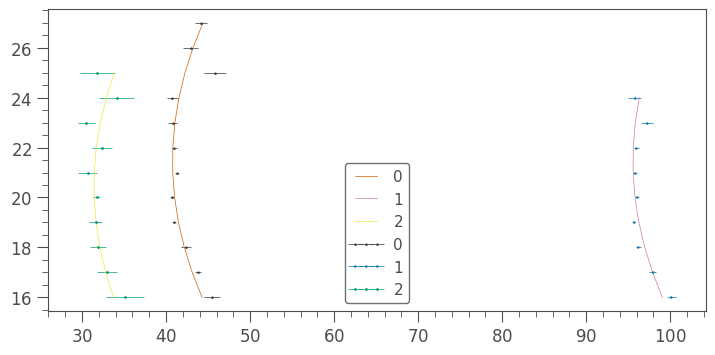

Running KIC: 10162436


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2193.29draws/s]


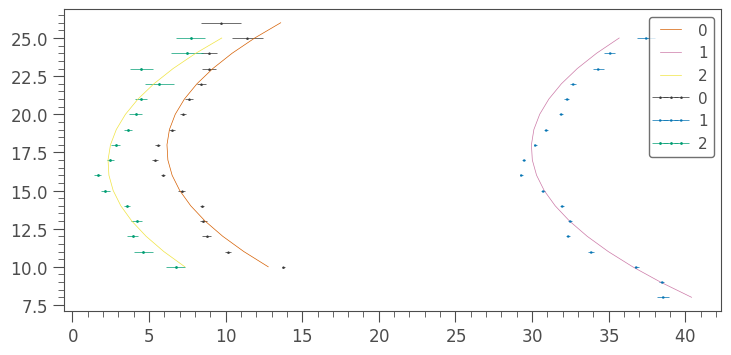

Running KIC: 10454113


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2424.76draws/s]


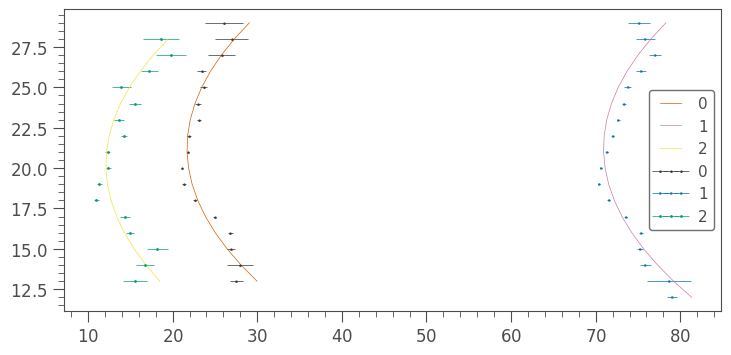

Running KIC: 10516096


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2553.08draws/s]


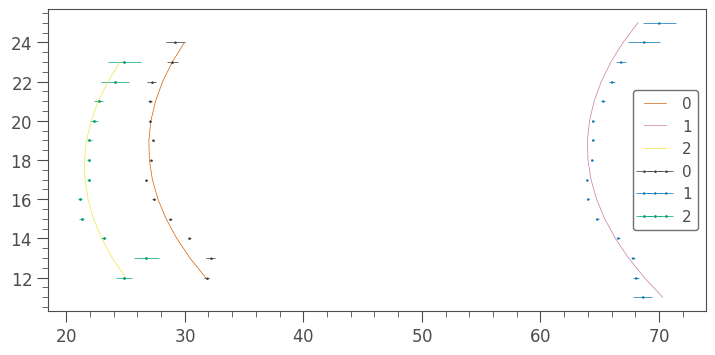

Running KIC: 10644253


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2168.12draws/s]


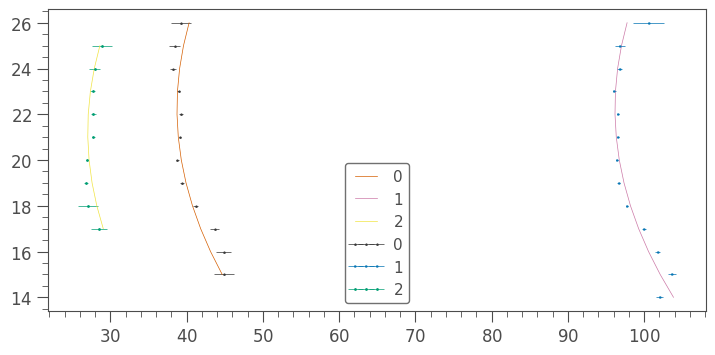

Running KIC: 10730618


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2202.83draws/s]


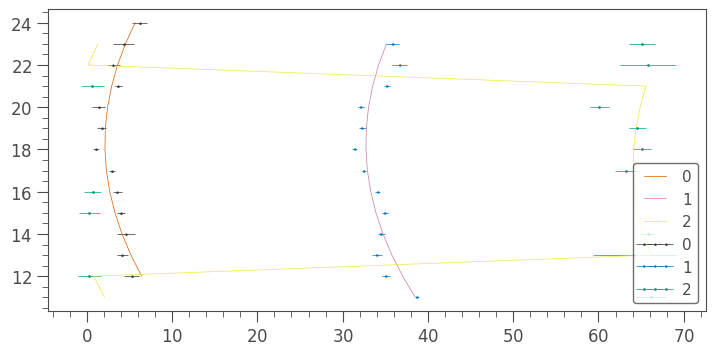

Running KIC: 10963065


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2598.07draws/s]


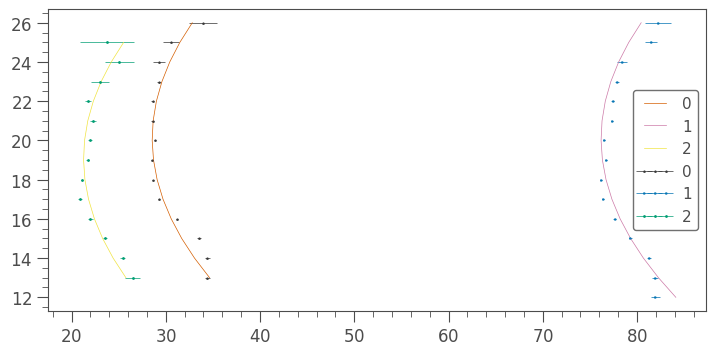

Running KIC: 11081729


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2313.87draws/s]


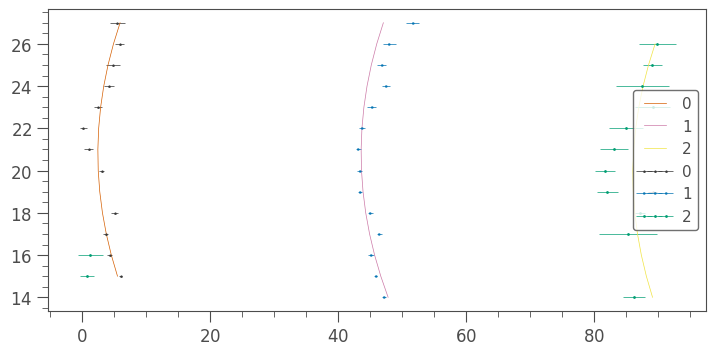

Running KIC: 11253226


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2211.80draws/s]


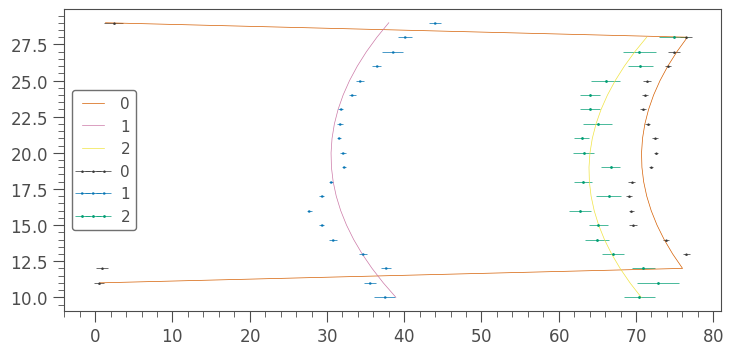

Running KIC: 11772920


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2516.70draws/s]


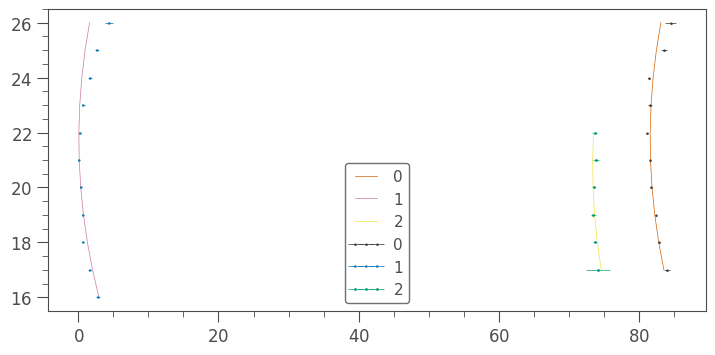

Running KIC: 12009504


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2299.77draws/s]


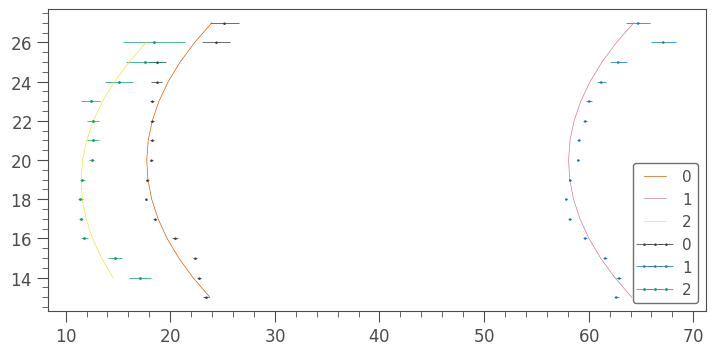

Running KIC: 12069127


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2236.99draws/s]


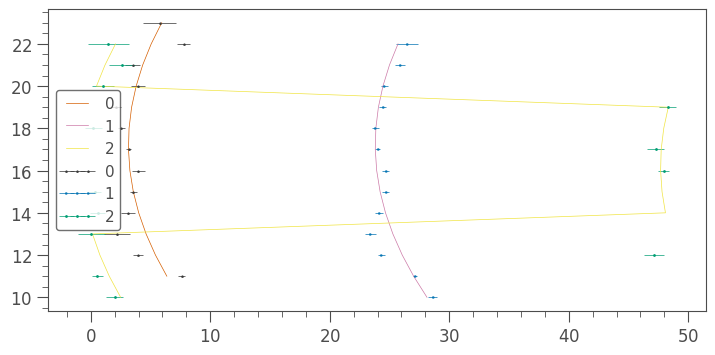

Running KIC: 12069424


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:10<00:00, 1888.55draws/s]


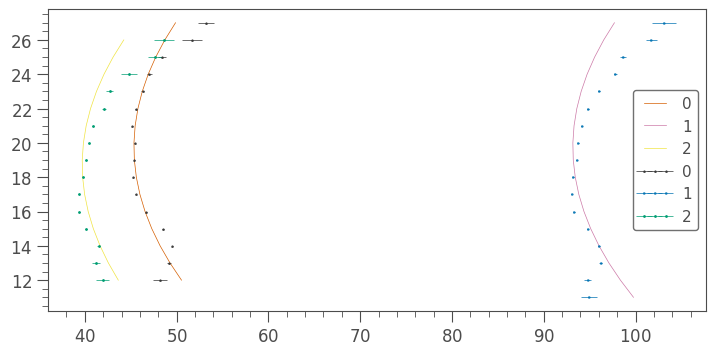

Running KIC: 12069449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2387.83draws/s]


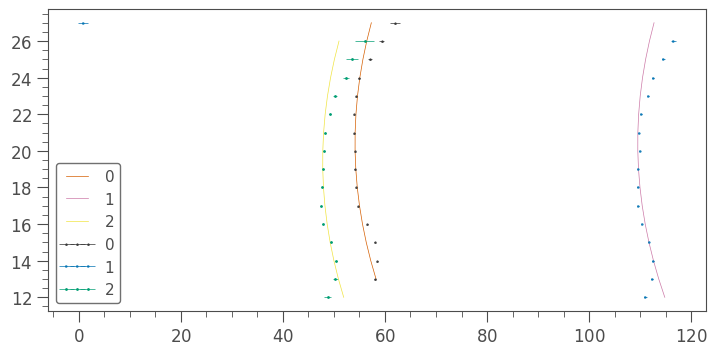

Running KIC: 12258514


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2035.76draws/s]


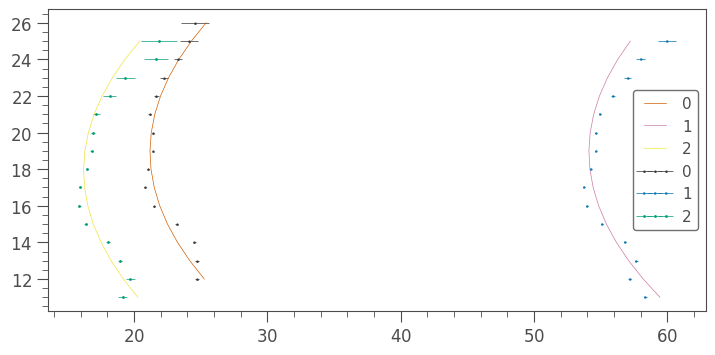

Running KIC: 12317678


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2222.47draws/s]


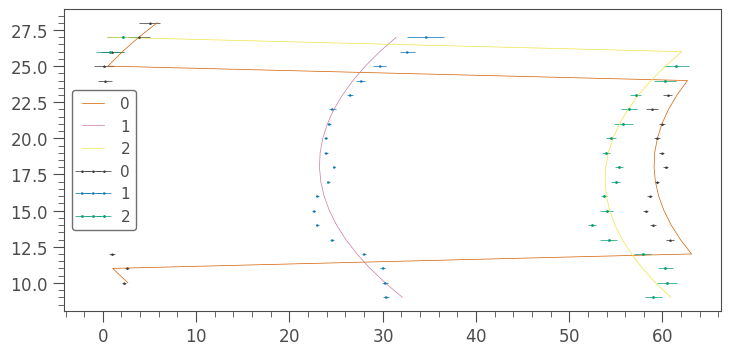

Running KIC: 3425851


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2361.85draws/s]


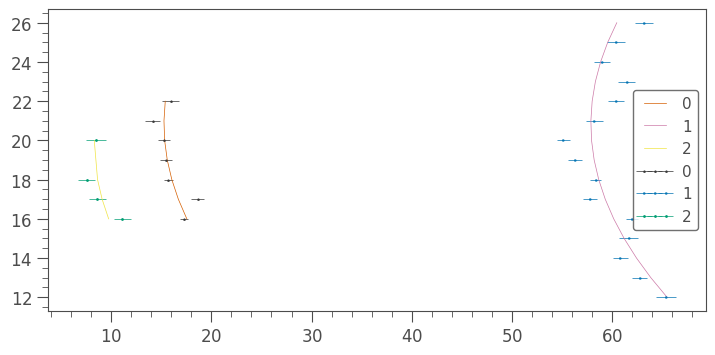

Running KIC: 3544595


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2354.43draws/s]


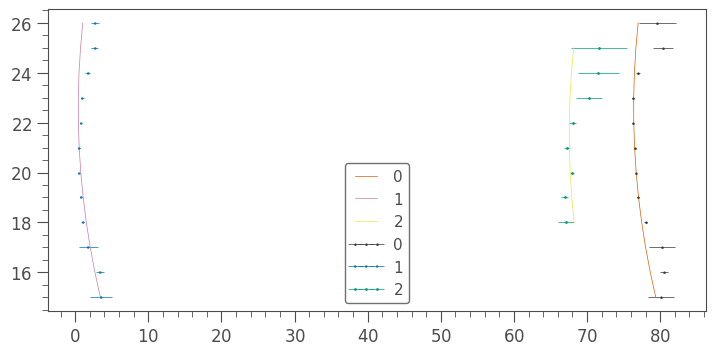

Running KIC: 4141376


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2382.62draws/s]


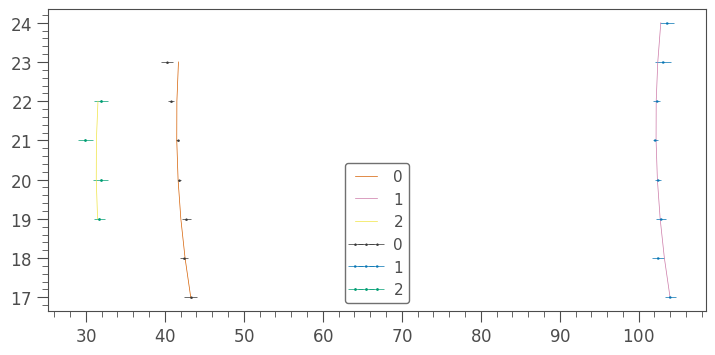

Running KIC: 4143755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2400.69draws/s]


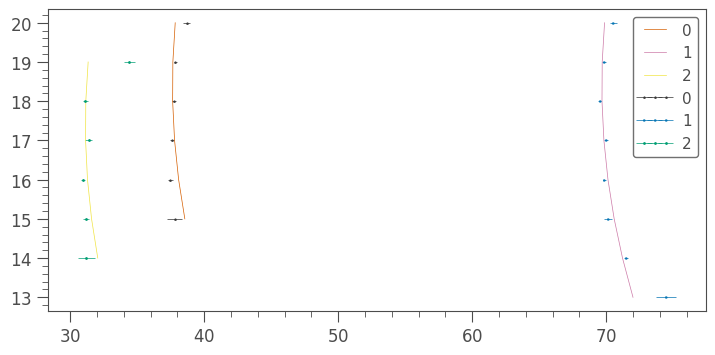

Running KIC: 4349452


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2386.58draws/s]


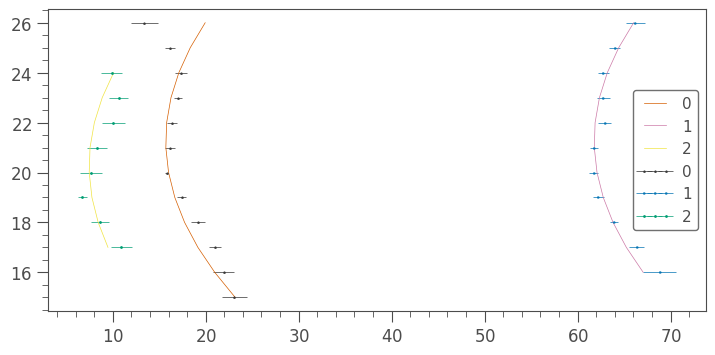

Running KIC: 4914423


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:10<00:00, 1899.41draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


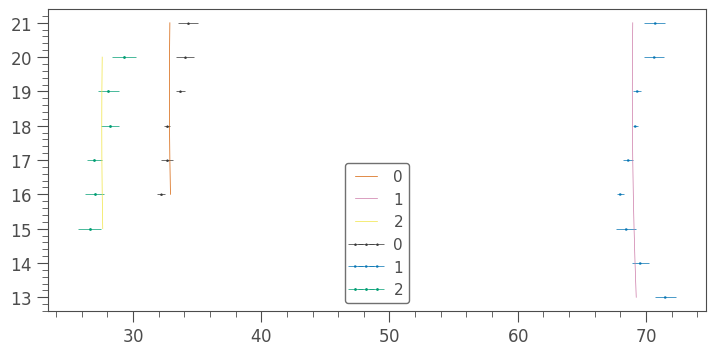

Running KIC: 5094751


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2128.07draws/s]
The acceptance probability does not match the target. It is 0.696250602060367, but should be close to 0.8. Try to increase the number of tuning steps.


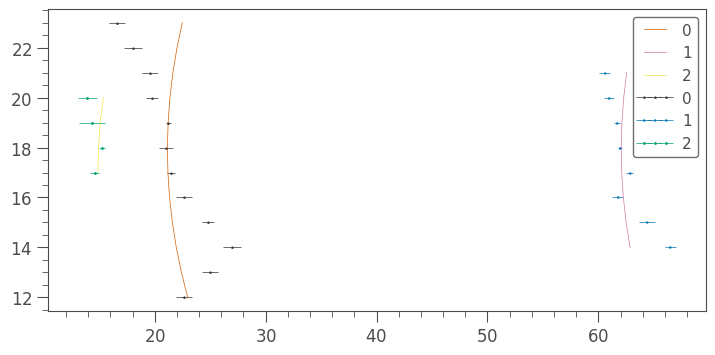

Running KIC: 5866724


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2495.40draws/s]


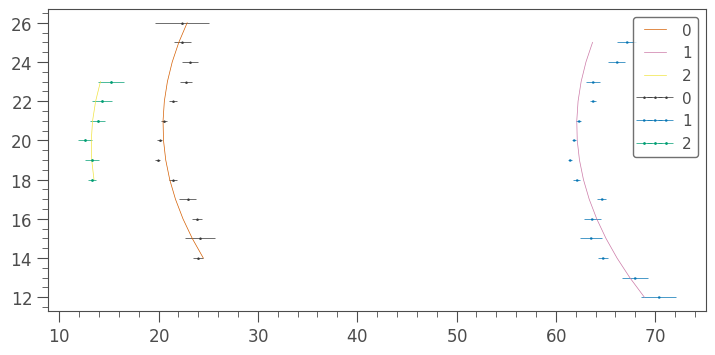

Running KIC: 6196457


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2325.34draws/s]


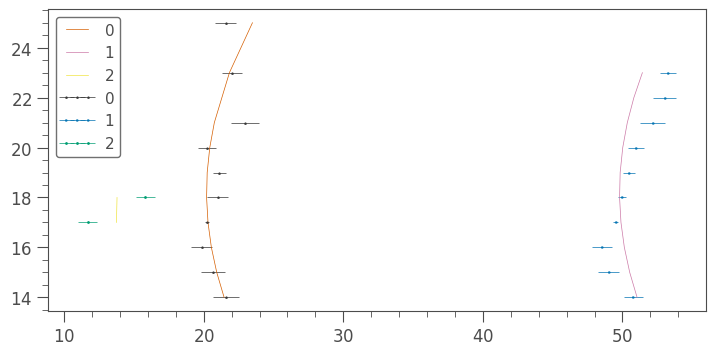

Running KIC: 6278762


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2087.41draws/s]


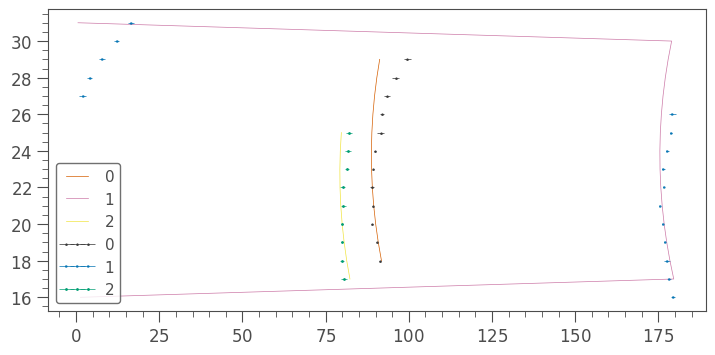

Running KIC: 6521045


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2346.32draws/s]


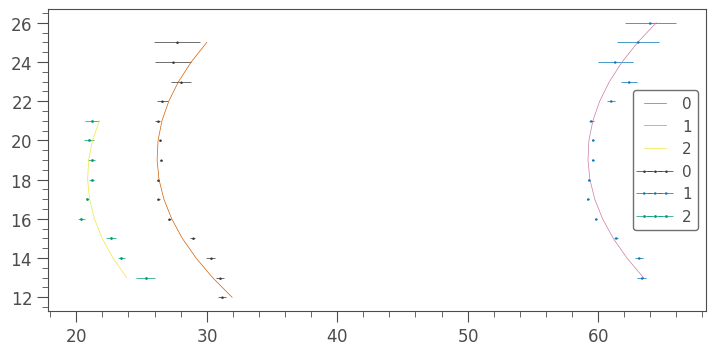

Running KIC: 7670943


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2520.57draws/s]


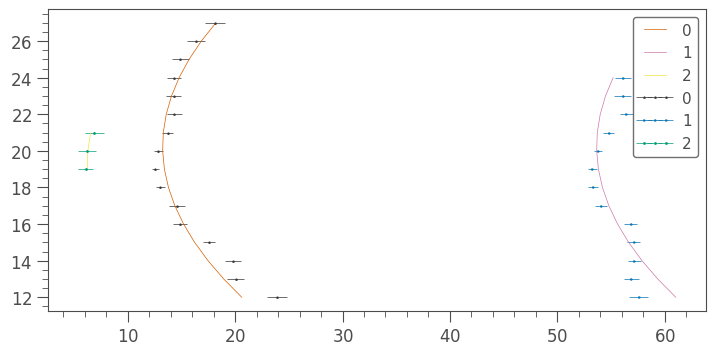

Running KIC: 8077137


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2441.54draws/s]


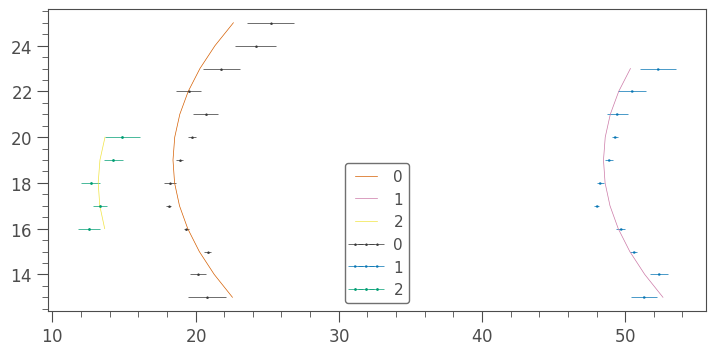

Running KIC: 8292840


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2454.13draws/s]


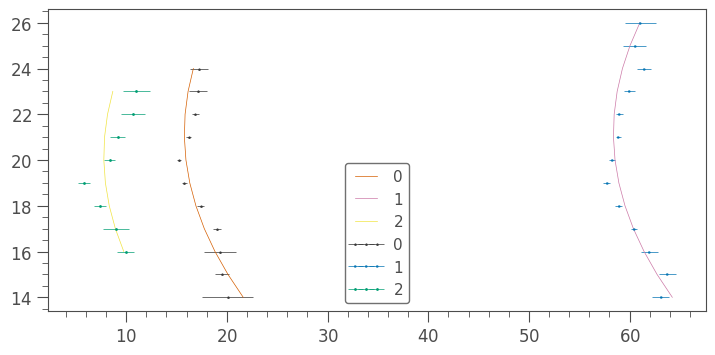

Running KIC: 8349582


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2163.59draws/s]


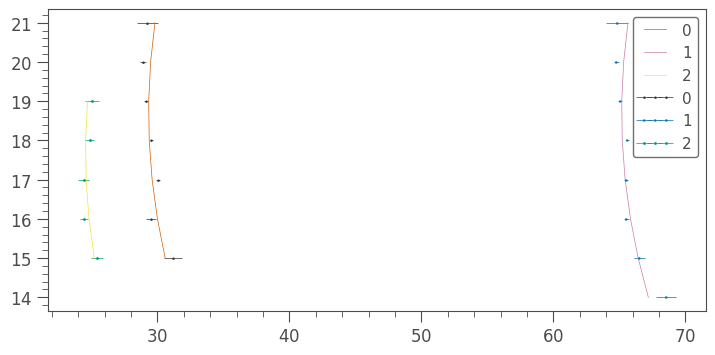

Running KIC: 8478994


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:12<00:00, 1632.59draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


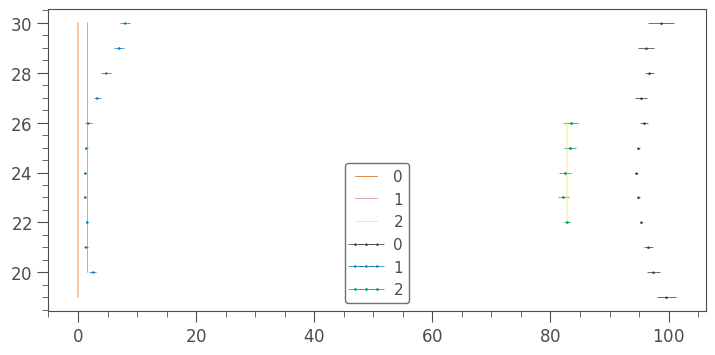

Running KIC: 8494142


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2487.63draws/s]


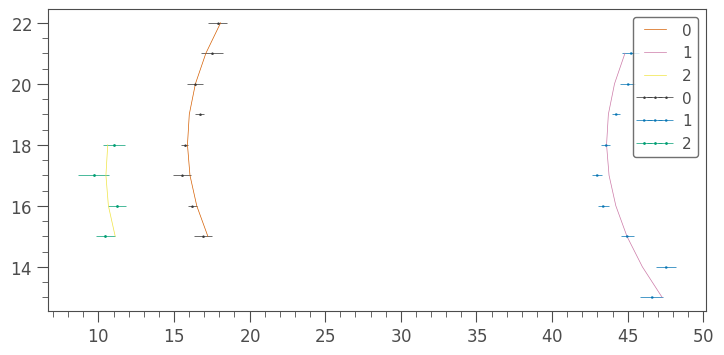

Running KIC: 8554498


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2097.53draws/s]


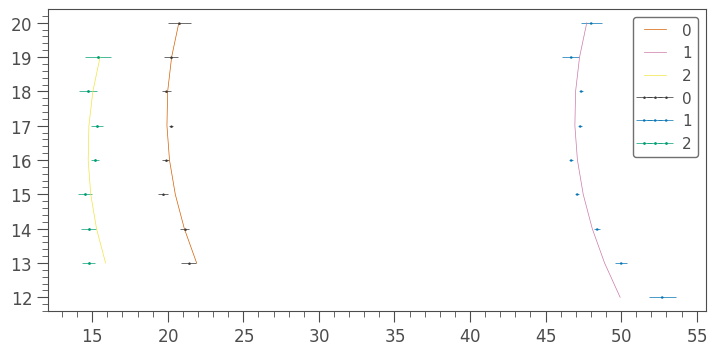

Running KIC: 8866102


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2467.63draws/s]


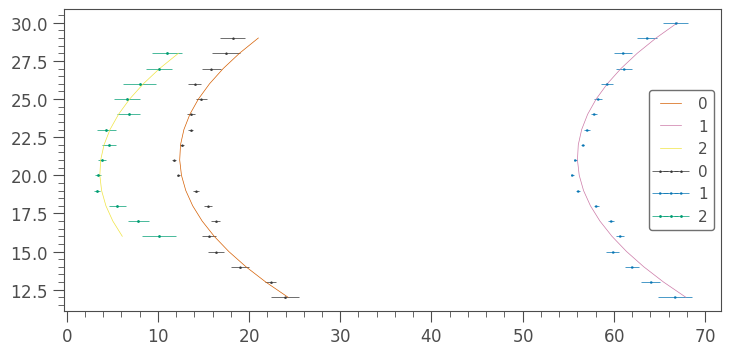

Running KIC: 9592705


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2371.80draws/s]


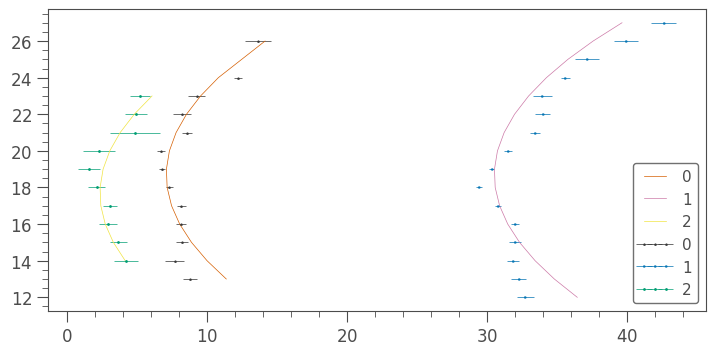

Running KIC: 10514430


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2206.42draws/s]


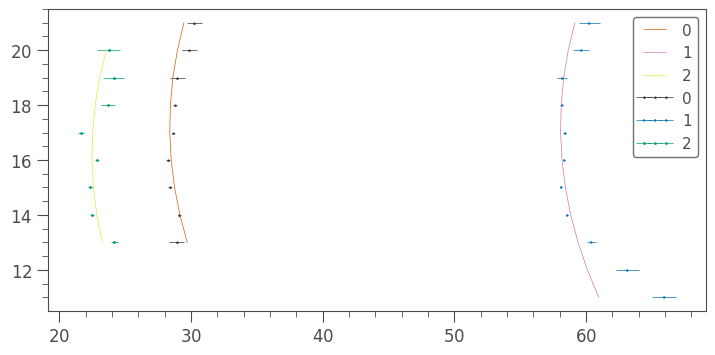

Running KIC: 10586004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2176.19draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7184866744886387, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


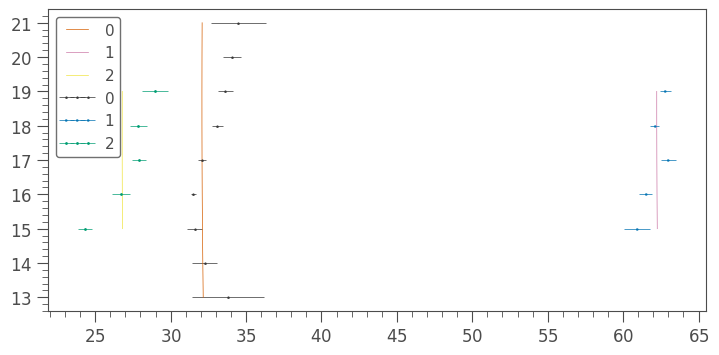

Running KIC: 10666592


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2503.77draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


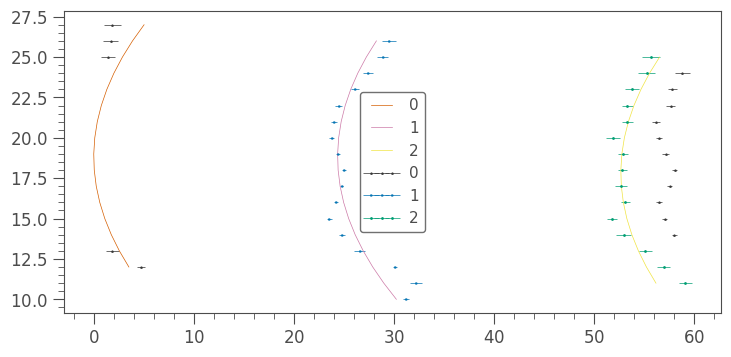

Running KIC: 11133306


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2108.09draws/s]


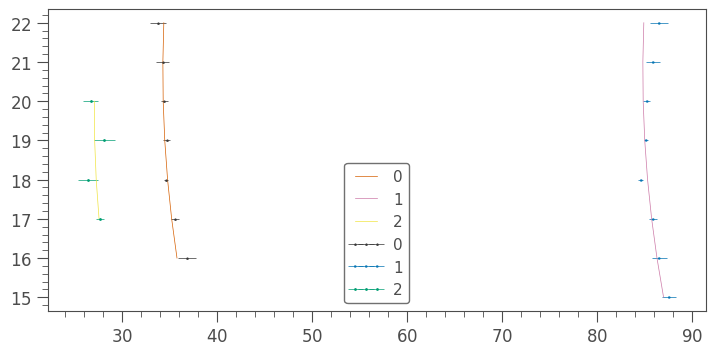

Running KIC: 11295426


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2481.07draws/s]


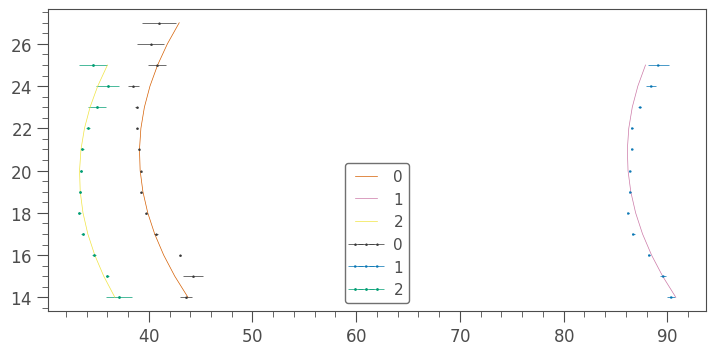

Running KIC: 11401755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2555.75draws/s]


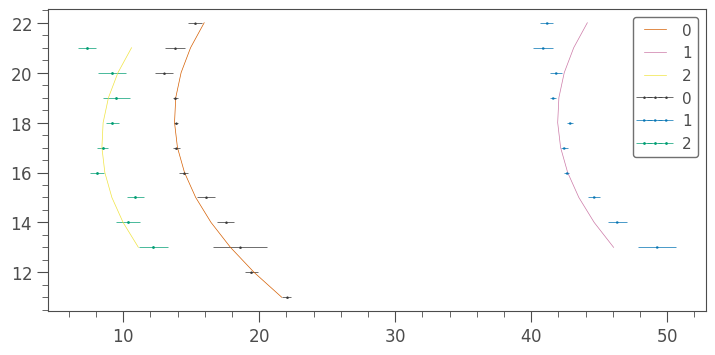

Running KIC: 11807274


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2485.67draws/s]


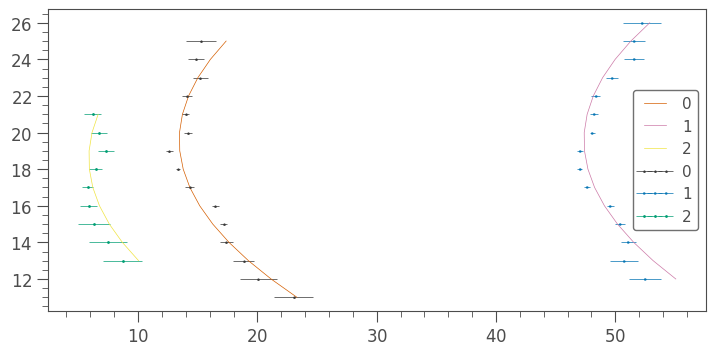

Running KIC: 11853905


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:09<00:00, 2168.14draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


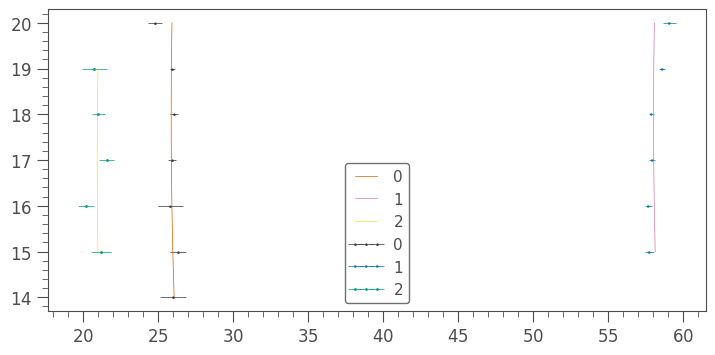

Running KIC: 11904151


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d02, d01, epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:08<00:00, 2483.62draws/s]


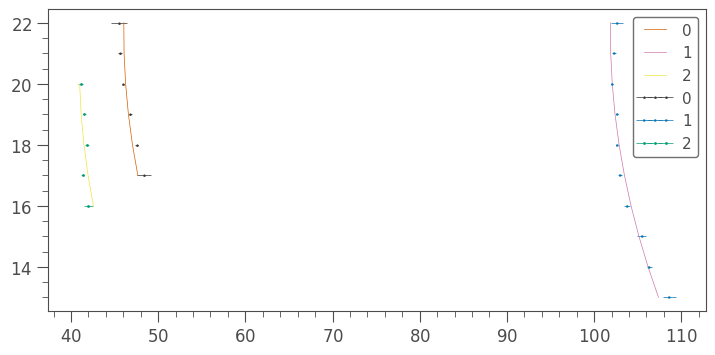

In [17]:
repeat = True
if not repeat:
    check = pd.read_csv('../../data/cadmium.csv', index_col=0)
    kics = check[~np.isfinite(check.d02)].KIC.values
    print('Starting at KIC: {}'.format(str(kics[0])))
elif repeat:
    kics = mal.KIC.values

for kic in kics:
    print('Running KIC: {}'.format(str(kic)))
    
    n0 = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].n.values
    n1 = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].n.values
    n2 = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].n.values

    numax_ = mal.loc[mal.KIC == kic].numax.values[0]
    deltanu_ = mal.loc[mal.KIC == kic].dnu.values[0]

    l0s = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].Freq.values
    e_l0s = cop.loc[cop.KIC == str(kic)].loc[cop.l==0].e_Freq.values
    l1s = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].Freq.values
    e_l1s = cop.loc[cop.KIC == str(kic)].loc[cop.l==1].e_Freq.values
    l2s = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].Freq.values
    e_l2s = cop.loc[cop.KIC == str(kic)].loc[cop.l==2].e_Freq.values 

    # Initiate the model
    mod = model(n0, n1, n2, numax_, deltanu_)
    
    # Run the model
    init=5000
    pm_model = pm.Model()
    with pm_model:
        #Parameters
        alpha = pm.HalfNormal('alpha', sigma=1., testval=0.02)
        epsilon = BoundedNormal('epsilon', mu=1., sigma=1., testval=1.)
        d01 = BoundedNormal('d01', mu=0.5, sigma=.1, testval=0.5)
        d02 = BoundedNormal('d02', mu=0.1,  sigma=.3, testval=0.1)

        # Model
        p = [alpha, epsilon, d01, d02]
        nul0s = pm.Deterministic('nul0s', mod.f0(p))
        nul1s = pm.Deterministic('nul1s', mod.f1(p))
        nul2s = pm.Deterministic('nul2s', mod.f2(p))

        like0 = pm.Normal('like0', mu=nul0s, sigma=e_l0s, observed=l0s)
        like1 = pm.Normal('like1', mu=nul1s, sigma=e_l1s, observed=l1s)
        like2 = pm.Normal('like2', mu=nul2s, sigma=e_l2s, observed=l2s)
        
        trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))
    

    res = [np.median(trace[label]) for label in ['alpha','epsilon','d01','d02']]

    with plt.style.context(ms.ms):
        fig, ax = plt.subplots()
        ax.errorbar(l0s%deltanu_, n0, xerr=e_l0s, fmt='^',label='0')
        ax.errorbar(l1s%deltanu_, n1, xerr=e_l1s, fmt='>',label='1')
        ax.errorbar(l2s%deltanu_, n2, xerr=e_l2s, fmt='o',label='2')

        ax.plot(mod.f0(res)%deltanu_, n0, label='0')
        ax.plot(mod.f1(res)%deltanu_, n1, label='1')
        ax.plot(mod.f2(res)%deltanu_, n2, label='2')

        ax.legend()
        plt.show()

    # Add the output to the array
    cadmium.loc[cadmium.KIC==kic, 'alpha'] = np.median(trace['alpha'])
    cadmium.loc[cadmium.KIC==kic, 'e_alpha'] = np.std(trace['alpha'])
    cadmium.loc[cadmium.KIC==kic, 'epsilon'] = np.median(trace['epsilon'])
    cadmium.loc[cadmium.KIC==kic, 'e_epsilon'] = np.std(trace['epsilon'])
    cadmium.loc[cadmium.KIC==kic, 'd01'] = np.median(trace['d01'])
    cadmium.loc[cadmium.KIC==kic, 'e_d01'] = np.std(trace['d01'])
    cadmium.loc[cadmium.KIC==kic, 'd02'] = np.median(trace['d02'])
    cadmium.loc[cadmium.KIC==kic, 'e_d02'] = np.std(trace['d02'])
    
    cadmium.to_csv('../../data/cadmium.csv')

In [18]:
cadmium

,KIC,alpha,e_alpha,epsilon,e_epsilon,d01,d02,e_d01,e_d02
0,1435467,2.602829e-03,1.136501e-04,1.114495e+00,1.340074e-03,0.459456,0.080642,0.001557,0.003036
1,2837475,2.208562e-03,1.251588e-04,9.117671e-01,1.780642e-03,0.468845,0.085375,0.002051,0.004396
2,3427720,1.996865e-03,3.904902e-05,1.358026e+00,4.446622e-04,0.468099,0.087238,0.000515,0.000720
3,3456181,3.644019e-03,1.682959e-04,9.915847e-01,2.320592e-03,0.426713,0.083744,0.002533,0.004240
4,3632418,3.534374e-03,4.962390e-05,1.116879e+00,7.910803e-04,0.434891,0.071409,0.000894,0.001472
5,3656476,1.376445e-03,6.009729e-05,1.446717e+00,3.048157e-04,0.448965,0.051153,0.000358,0.000470
6,3735871,1.726545e-03,7.242249e-05,1.325119e+00,5.553076e-04,0.467922,0.089582,0.000789,0.001464
7,4914923,1.854503e-03,4.811886e-05,1.378761e+00,3.303563e-04,0.446548,0.061735,0.000426,0.000694
8,5184732,1.600798e-03,3.728494e-05,1.375901e+00,2.716792e-04,0.468134,0.063294,0.000368,0.000526
9,5773345,3.266967e-03,6.407720e-05,1.082937e+00,1.310109e-03,0.466551,0.072929,0.001617,0.003895


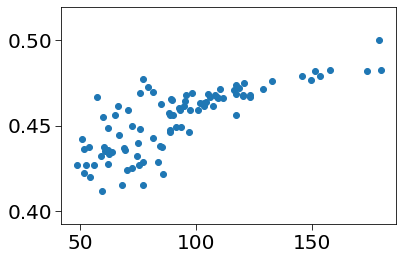

In [24]:
plt.scatter(mal.dnu, cadmium.d01)

Lets just correct for KIC 8478994, and reset its $\delta\nu01$ to $\Delta\nu / 2$

In [23]:
cadmium.loc[cadmium.KIC==8478994, 'd01'] = 0.5

In [25]:
cadmium.to_csv('../../data/cadmium.csv')

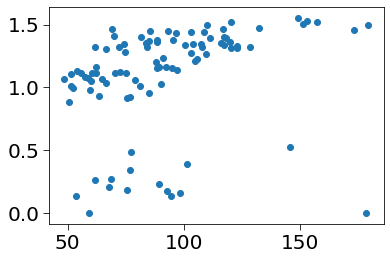

In [26]:
plt.scatter(mal.dnu, cadmium.epsilon)

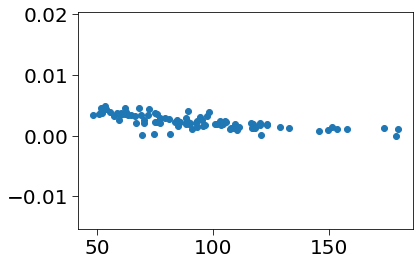

In [27]:
plt.scatter(mal.dnu, cadmium.alpha)